# Code 3: Adversarial Training and Watermarking

> Dissertation Task-1 (6812009)

In [1]:
pip install adversarial-robustness-toolbox

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from art.attacks.evasion import FastGradientMethod, DeepFool, NewtonFool, CarliniL2Method, BasicIterativeMethod
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt

# Loading Olivetti Faces dataset
data = fetch_olivetti_faces()
X = data.images
y = data.target

# Reshaping data to fit the model
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1).astype(np.float32)

# One-hot encoding the labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

In [3]:
# Function to add watermark to dataset
def add_watermark_to_dataset(X, watermark_intensity=0.01):
    np.random.seed(42)
    watermark = np.random.normal(scale=watermark_intensity, size=X.shape)
    watermarked_X = X + watermark
    watermarked_X = np.clip(watermarked_X, 0, 1)
    return watermarked_X

# Defining noise addition functions
def add_gaussian_noise(X, mean=0, var=0.1):
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, X.shape)
    X_noisy = X + gaussian
    X_noisy = np.clip(X_noisy, 0, 1)
    return X_noisy

def add_salt_and_pepper_noise(X, amount=0.05, salt_vs_pepper=0.5):
    X_noisy = np.copy(X)
    num_salt = np.ceil(amount * X.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X.size * (1.0 - salt_vs_pepper))

    # Add salt
    coords = [np.random.randint(0, i, int(num_salt)) for i in X.shape]
    X_noisy[tuple(coords)] = 1

    # Add pepper
    coords = [np.random.randint(0, i, int(num_pepper)) for i in X.shape]
    X_noisy[tuple(coords)] = 0

    return X_noisy

def add_speckle_noise(X):
    gaussian = np.random.randn(*X.shape)
    X_noisy = X + X * gaussian
    X_noisy = np.clip(X_noisy, 0, 1)
    return X_noisy

def add_poisson_noise(X):
    vals = len(np.unique(X))
    vals = 2 ** np.ceil(np.log2(vals))
    X_noisy = np.random.poisson(X * vals) / float(vals)
    X_noisy = np.clip(X_noisy, 0, 1)
    return X_noisy

def add_uniform_noise(X, low=-0.1, high=0.1):
    uniform = np.random.uniform(low, high, X.shape)
    X_noisy = X + uniform
    X_noisy = np.clip(X_noisy, 0, 1)
    return X_noisy

# Function to augment dataset with noisy images
def augment_dataset_with_noise(X, y):
    X_augmented = []
    y_augmented = []

    noise_functions = [
        add_gaussian_noise,
        add_salt_and_pepper_noise,
        add_speckle_noise,
        add_poisson_noise,
        add_uniform_noise
    ]

    for i in range(len(X)):
        X_augmented.append(X[i])
        y_augmented.append(y[i])
        for noise_func in noise_functions:
            noisy_image = noise_func(X[i])
            noisy_image = add_watermark_to_dataset(noisy_image[np.newaxis, ...])[0]  # Adding watermark to noisy images
            X_augmented.append(noisy_image)
            y_augmented.append(y[i])

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    return X_augmented, y_augmented

In [4]:
# Watermarking the dataset
X_watermarked = add_watermark_to_dataset(X)

# Augmenting the dataset
X_augmented, y_augmented = augment_dataset_with_noise(X_watermarked, y)

# Splitting the augmented data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)

# Defining Layer Watermarking
class WatermarkLayer(tf.keras.layers.Layer):
    def __init__(self, intensity=0.001, **kwargs):
        super(WatermarkLayer, self).__init__(**kwargs)
        self.intensity = intensity

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=input_shape[1:],
                                      initializer='uniform',
                                      trainable=True)
        super(WatermarkLayer, self).build(input_shape)

    def call(self, inputs):
        return inputs + self.kernel * self.intensity

    def compute_output_shape(self, input_shape):
        return input_shape

# Defining a function to create the CNN model
def create_model():
    model = Sequential([
        WatermarkLayer(intensity=0.001, input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        WatermarkLayer(intensity=0.001),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        WatermarkLayer(intensity=0.001),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initializing the model
model = create_model()

# Training the model with noise augmentation
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluating the model on augmented dataset
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')
print(f'Test loss: {loss:.4f}')

<ipython-input-4-e7b24f6928b0>:13: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(WatermarkLayer, self).__init__(**kwargs)


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0283 - loss: 3.7059
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0559 - loss: 3.6149
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2556 - loss: 2.8840
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5085 - loss: 1.6695
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6617 - loss: 1.1320
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7632 - loss: 0.7816
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7789 - loss: 0.6980
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8039 - loss: 0.5766
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8361 - loss: 0.4944
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8493 - loss: 0.4530
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.4090
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - 

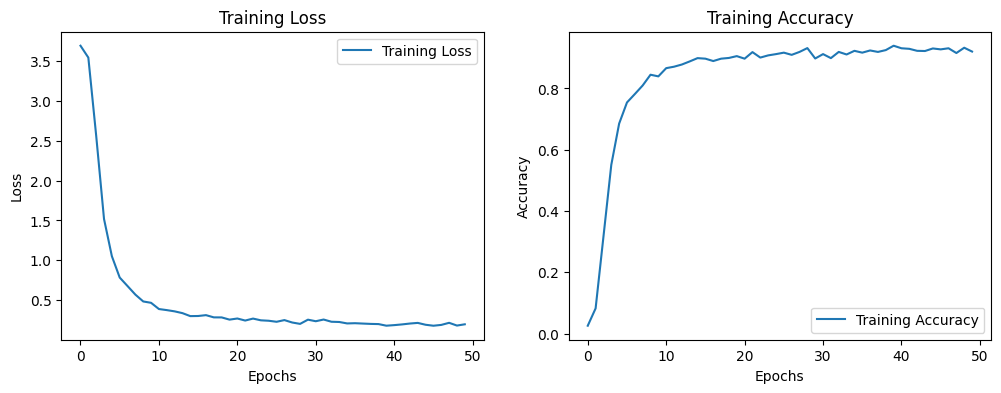

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


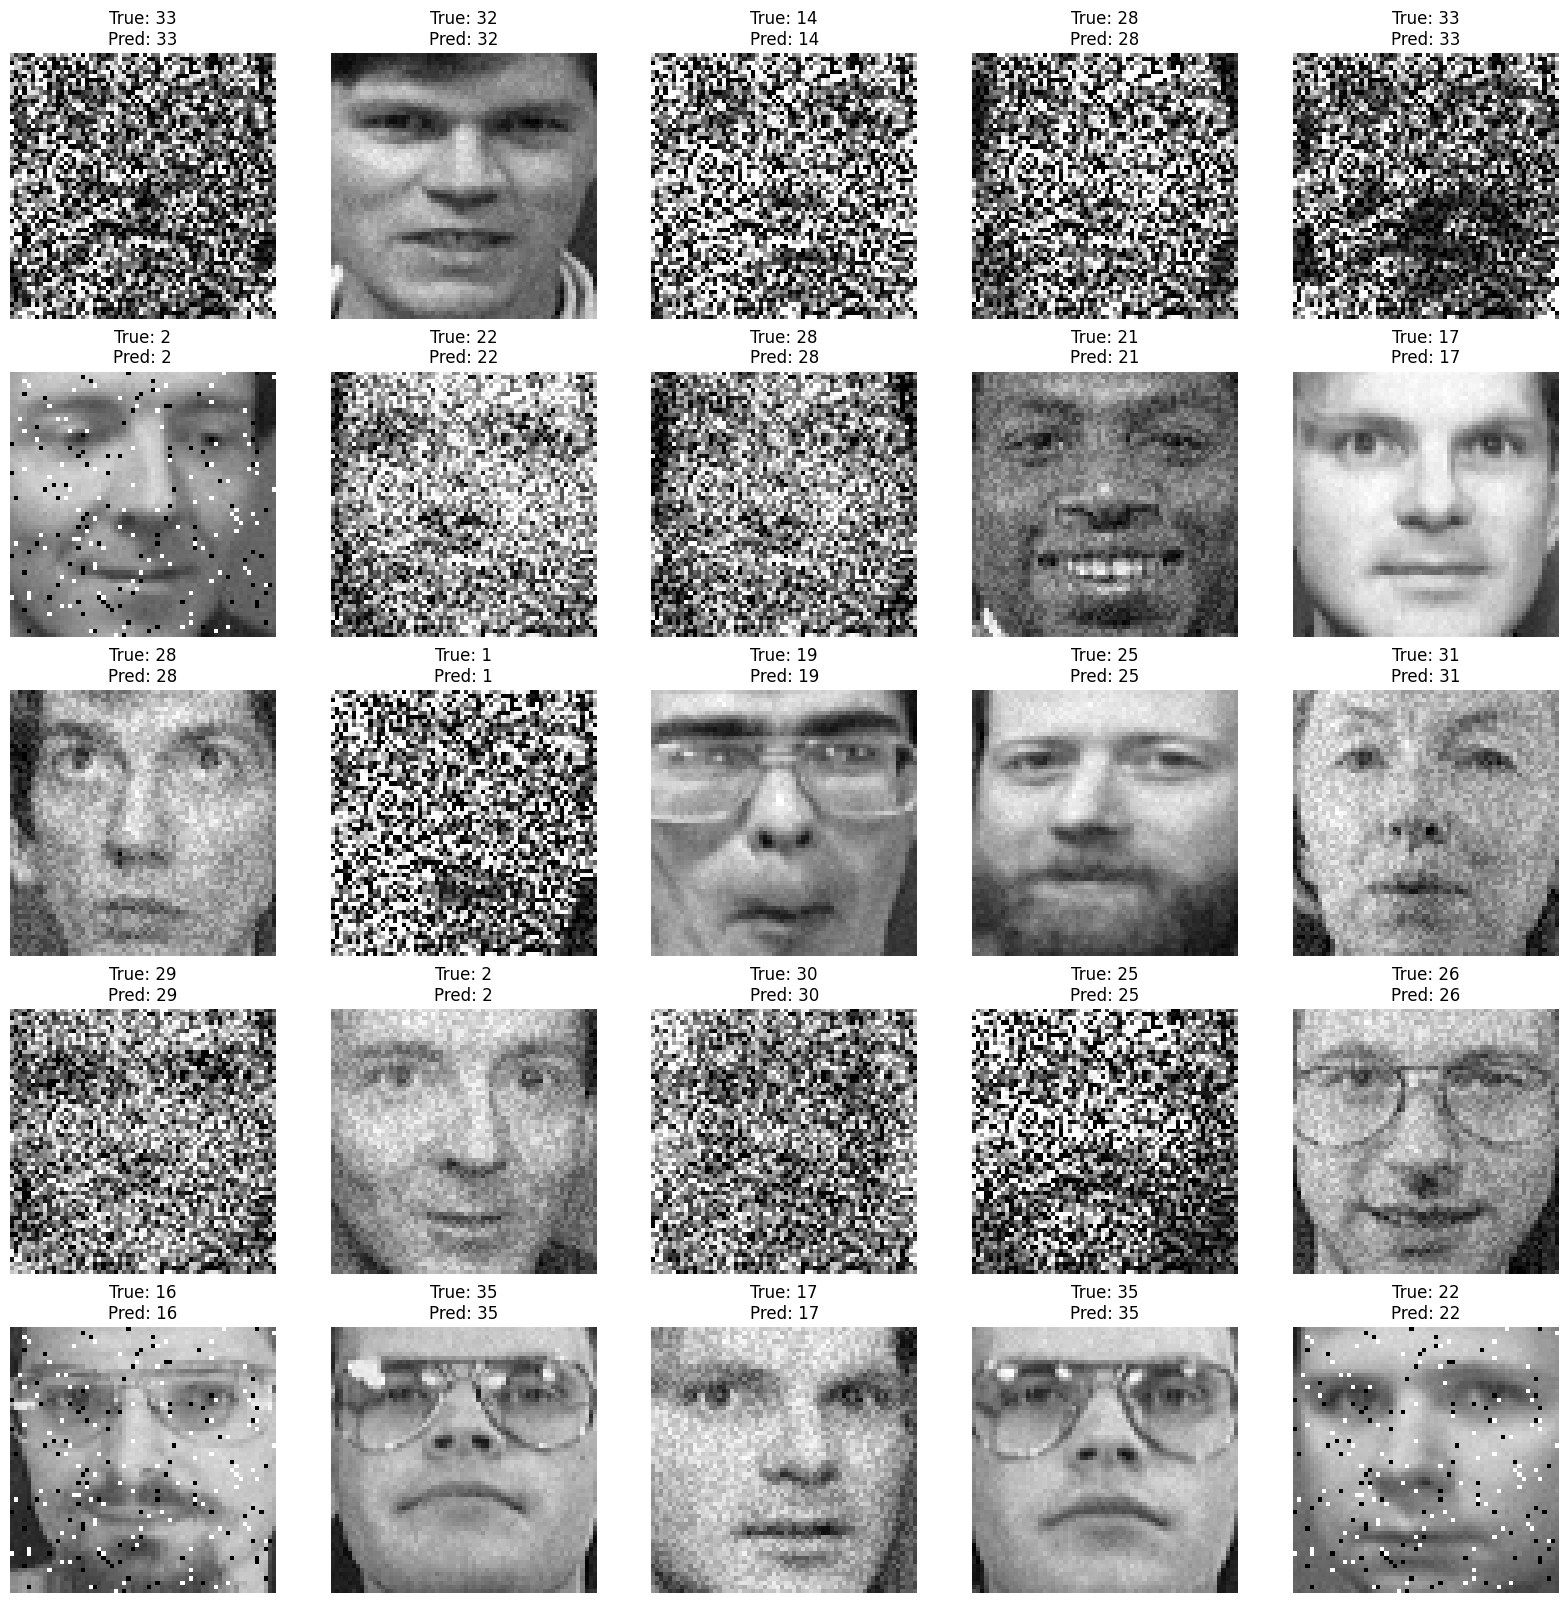

In [5]:
# Plotting training loss and accuracy
plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

# Predicting on the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Visualizing test predictions along with the images and their predicted labels
plt.figure(figsize=(20, 20))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[i].reshape(X.shape[1], X.shape[2]), cmap='gray')
    plt.title(f'True: {true_classes[i]}\nPred: {predicted_classes[i]}')
    plt.axis('off')

plt.show()

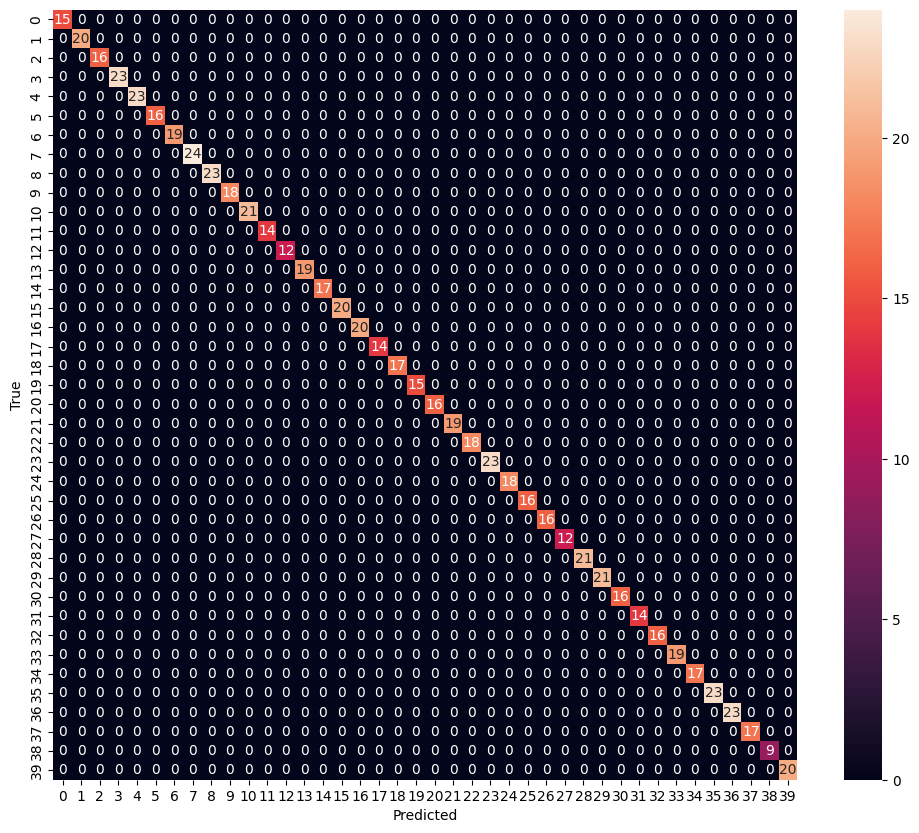

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00        17
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        20
   

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes)
print("Classification Report:\n", report)

# Cohen's Kappa Score
kappa_score = cohen_kappa_score(true_classes, predicted_classes)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

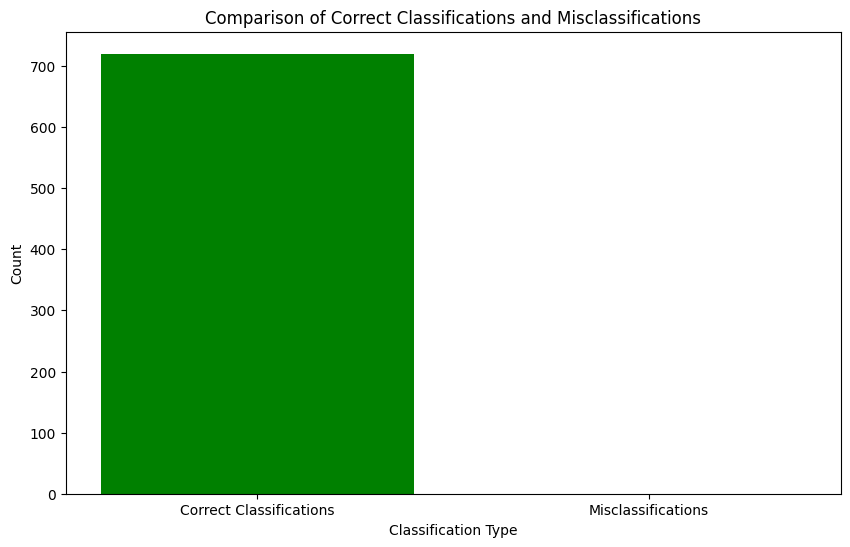

In [7]:
# Calculating the number of correct and incorrect classifications
correct_classifications = np.sum(true_classes == predicted_classes)
misclassifications = np.sum(true_classes != predicted_classes)

labels = ['Correct Classifications', 'Misclassifications']
counts = [correct_classifications, misclassifications]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Classification Type')
plt.ylabel('Count')
plt.title('Comparison of Correct Classifications and Misclassifications')
plt.show()

In [8]:
# Defining the loss function used in the original model
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Creating ART classifier with the specified loss function
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(64, 64, 1),
    loss_object=loss_object,
)

# List of attacks to use for adversarial training
attacks = [
    FastGradientMethod(estimator=classifier, eps=0.03)
]

# Adversarial training loop
epochs = 50
batch_size = 32

# To store loss and accuracy
history = {'loss': [], 'accuracy': []}

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    num_batches = int(np.ceil(len(X_train) / batch_size))

    epoch_loss = 0
    epoch_accuracy = 0

    for i in range(num_batches):
        start = i * batch_size
        end = min(start + batch_size, len(X_train))
        x_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Generating adversarial examples
        adv_examples = []
        for attack in attacks:
            adv_x = attack.generate(x=x_batch)
            adv_examples.append(adv_x)

        # Concatenating original and adversarial examples
        x_adv_train = np.concatenate([x_batch] + adv_examples)
        y_adv_train = np.concatenate([y_batch] * (len(attacks) + 1))

        # Training on the combined dataset
        batch_loss, batch_accuracy = model.train_on_batch(x_adv_train, y_adv_train)
        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy

    # Calculating average loss and accuracy for the epoch
    epoch_loss /= num_batches
    epoch_accuracy /= num_batches
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)
    print(f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy after adversarial training: {accuracy:.4f}')

Epoch 1/50


Loss: 0.4914, Accuracy: 0.8512
Epoch 2/50
Loss: 0.5612, Accuracy: 0.8230
Epoch 3/50
Loss: 0.5433, Accuracy: 0.8246
Epoch 4/50
Loss: 0.5247, Accuracy: 0.8286
Epoch 5/50
Loss: 0.5092, Accuracy: 0.8321
Epoch 6/50
Loss: 0.4978, Accuracy: 0.8355
Epoch 7/50
Loss: 0.4850, Accuracy: 0.8386
Epoch 8/50
Loss: 0.4697, Accuracy: 0.8435
Epoch 9/50
Loss: 0.4572, Accuracy: 0.8474
Epoch 10/50
Loss: 0.4430, Accuracy: 0.8512
Epoch 11/50
Loss: 0.4312, Accuracy: 0.8541
Epoch 12/50
Loss: 0.4227, Accuracy: 0.8564
Epoch 13/50
Loss: 0.4157, Accuracy: 0.8583
Epoch 14/50
Loss: 0.4088, Accuracy: 0.8604
Epoch 15/50
Loss: 0.4027, Accuracy: 0.8625
Epoch 16/50
Loss: 0.3960, Accuracy: 0.8646
Epoch 17/50
Loss: 0.3895, Accuracy: 0.8665
Epoch 18/50
Loss: 0.3839, Accuracy: 0.8682
Epoch 19/50
Loss: 0.3786, Accuracy: 0.8697
Epoch 20/50
Loss: 0.3744, Accuracy: 0.8710
Epoch 21/50
Loss: 0.3707, Accuracy: 0.8723
Epoch 22/50
Loss: 0.3665, Accuracy: 0.8739
Epoch 23/50
Loss: 0.3629, Accuracy: 0.8751
Epoch 24/50
Loss: 0.3591, Accur

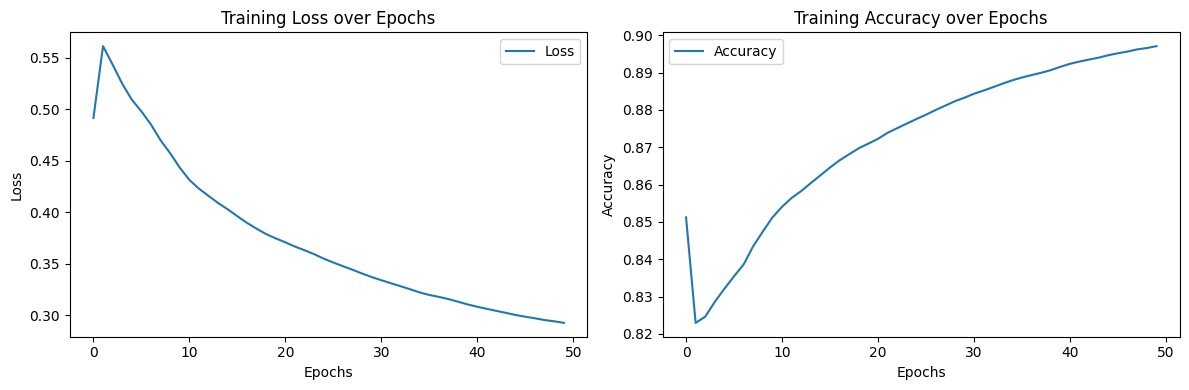

In [9]:
# Plotting the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


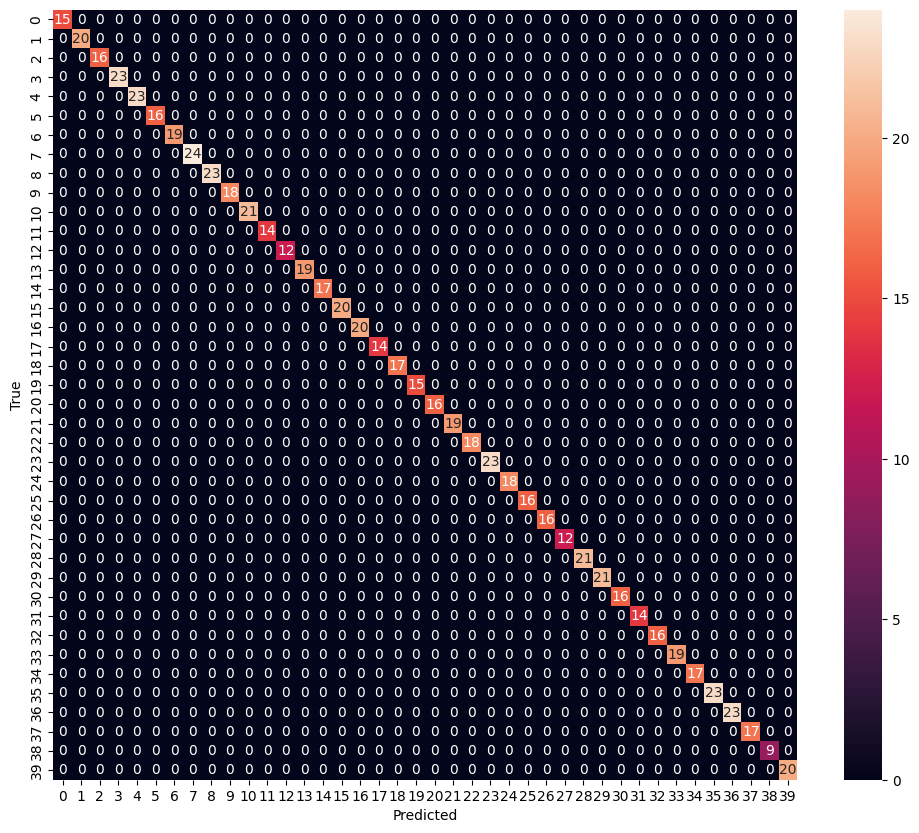

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00        17
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        20
    

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predicting the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generating classification report
class_report = classification_report(y_true, y_pred_classes)
print('Classification Report:')
print(class_report)

In [12]:
# Saving the robust CNN model to a file
model.save('FR_Olivetti_Robust_CNN_Model.h5')